In [687]:
import numpy as np
import pandas as pd
import re
from datetime import date

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

import configparser
import pymongo

In [688]:
config = configparser.ConfigParser()
config.read('../database-dev/auth/config.ini')

MONGO_LOCAL = config.get('mongodb', 'MONGO_LOCAL')
MONGO_DB = config.get('mongodb', 'MONGO_DB')
client = pymongo.MongoClient(MONGO_LOCAL)
db = client.get_database(MONGO_DB)
collection = db['reps']

In [689]:
proj_dict = {
    'first_name': 1,
    'middle_name': 1,
    'last_name': 1,
    'dob': 1,
    'gender': 1,
    'current_party': 1,
    'state': 1,
    'roles': 1,
    'education': 1
}
results = collection.find({'in_office': True}, proj_dict)
df = pd.DataFrame(results)

## Age and Terms Served

In [690]:
def get_age(dob):
    today = date.today()
    age = today.year - dob.year - ((today.month, today.day) < (dob.month, dob.day))
    
    return age

In [691]:
df['dob'] = df['dob'].map(lambda x: pd.to_datetime(x).date())
df['age'] = np.vectorize(get_age)(df['dob'].values)
df['terms'] = np.vectorize(lambda x: len(x))(df['roles'])

In [692]:
df['age'].describe()

count    438.000000
mean      57.899543
std       12.011206
min       25.000000
25%       49.000000
50%       58.000000
75%       67.000000
max       87.000000
Name: age, dtype: float64

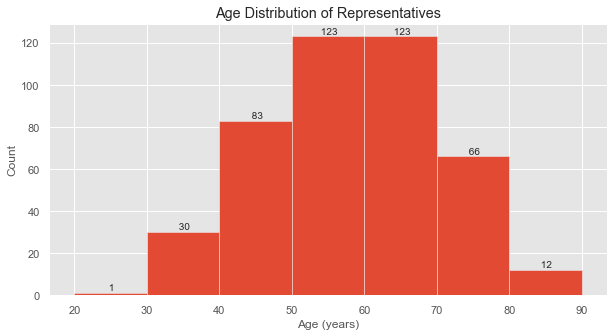

In [693]:
fig = plt.figure(figsize=(10,5))
ax = plt.hist(df['age'], bins=range(20, 100, 10))
for i, p in enumerate(ax[2].patches):
    xy = p.get_xy()
    plt.annotate(
        text='{val: .0f}'.format(val=ax[0][i]),
        xy=(p.get_x() + p.get_width() / 2, p.get_height()),
        ha='center', va='center', xytext=(0, 5), textcoords='offset points'
    )
plt.title('Age Distribution of Representatives')
plt.xlabel('Age (years)')
plt.ylabel('Count')
plt.show()

## Degrees and Institutions

In [694]:
df['education'] = df['education'].map(lambda x: x == None and [['HS', 'HS']] or x)
df['education'] = df['education'].map(lambda x: x == [] and [['HS', 'HS']] or x)

In [695]:
df['degrees'] = df['education'].map(lambda x: [ edu[0] for edu in x ])
df['institutions'] = df['education'].map(lambda x: [ edu[1] for edu in x ])

In [696]:
df.drop(columns='education', inplace=True)

In [697]:
degree_list = np.concatenate(df['degrees'])
degree_list = set(degree_list)

In [698]:
print(degree_list)

{'MPH', 'JD', 'MBA', 'BDIV', 'DMIN', 'HS', 'MS', 'THM', 'PHARMD', 'MSN', 'BS', 'BSFS', 'GRCERT', 'SYC', 'MD', 'AAS', 'DMD', 'DPA', 'AA', 'DDS', 'DVM', 'BA', 'BPA', 'MSEM', 'BSN', 'DPM', 'MFA', 'MSW', 'AB', 'MHS', 'MPA', 'ALB', 'AS', 'BGS', 'DPHIL', 'MPP', 'MSS', 'EDD', 'BBA', 'LLM', 'PHD', 'LLB', 'MPHIL', 'GRDIP', 'MACC', 'MUP', 'MIA', 'MED', 'MSC', 'MDIV', 'MA'}


In [699]:
# Dictionary to bin categories
degree_dict = {
    'Bachelors': [
        'BS', 'BA', 'AB', 'BPA', 'BBA', 'ALB', 'LLB', 'BDIV',
        'BSFS', 'BPA', 'BSN', 'BGS'
    ],
    'Masters': [
        'MPA', 'MA', 'MSW', 'MS', 'MPP', 'MDIV', 'THM', 'MUP',
        'MHS', 'SYC', 'GRCERT', 'MPHIL', 'MIA', 'MSS', 'MPH',
        'MACC', 'MFA', 'MED', 'MPH', 'MSEM', 'MSC'
    ],
    'Doctorate': ['PHD', 'DPA', 'EDD', 'PHARMD', 'DMIN', 'DPHIL'],
    'MBA': ['MBA'],
    'Medicine': ['MD', 'DPM'],
    'Veterinary': ['DVM'],
    'Nursing': ['GRDIP', 'MSN'],
    'Dental': ['DDS', 'DMD'],
    'Law': ['JD', 'LLM'],
    'HS': ['HS'],
    'Associates': ['AA', 'AAS', 'AS']
}

# Dictionary for average duration of degree completion
time_dict = {
    'Bachelors': 4,
    'Masters': 2,
    'Doctorate': 6,
    'MBA': 2,
    'Medicine': 6,
    'Nursing': 2,
    'Dental': 4,
    'Law': 2,
    'HS': 0,
    'Associates': 2,
    'Veterinary': 4
}

In [700]:
# Create invert k, v
map_dict = {}
for k, vs in degree_dict.items():
    for v in vs:
        map_dict[v] = k

In [701]:
# Group degrees and calculate years of post-secondary education
df['degree_groups'] = df['degrees'].map(lambda degs: [ map_dict[deg] for deg in degs ])
df['post_sec_years'] = df['degree_groups'].map(
    lambda degs: sum([ time_dict[deg] for deg in degs ])
)

In [702]:
# Institutions by graduates
colleges_dict = {}
for edus in df['institutions']:
    insts = []
    for edu in edus:
        # Prevent duplicate institutions by rep
        if edu in insts:
            pass
        else:
            if edu not in colleges_dict.keys():
                colleges_dict[edu] = 0
            colleges_dict[edu] += 1

tups = sorted(colleges_dict.items(), key=lambda x: x[1], reverse=True)
colleges_dict = { k: v for k, v in tups }
del colleges_dict['HS']

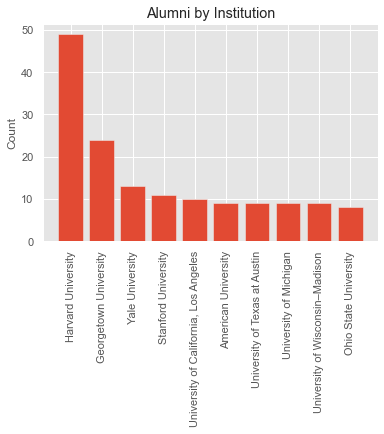

In [703]:
x = list(colleges_dict.keys())[:10]
y = list(colleges_dict.values())[:10]
plt.bar(x, y)
plt.xticks(rotation=90)
plt.title('Alumni by Institution')
plt.ylabel('Count')
plt.show()

In [704]:
df['has_bach'] = df['degree_groups'].map(lambda x: 'Bachelors' in x)
df['has_master'] = df['degree_groups'].map(lambda x: 'Masters' in x)
df['has_business'] = df['degree_groups'].map(lambda x: 'MBA' in x)
df['has_pro'] = df['degree_groups'].map(
    lambda x:
    ('Law' in x) or
    ('Medicine' in x) or
    ('Dental' in x) or 
    ('Veterinary' in x) or
    ('Nursing' in x)
)
df['has_doctorate'] = df['degree_groups'].map(lambda x: 'Doctorate' in x)
df['no_degree'] = df['degree_groups'].map(lambda x: 'HS' in x)

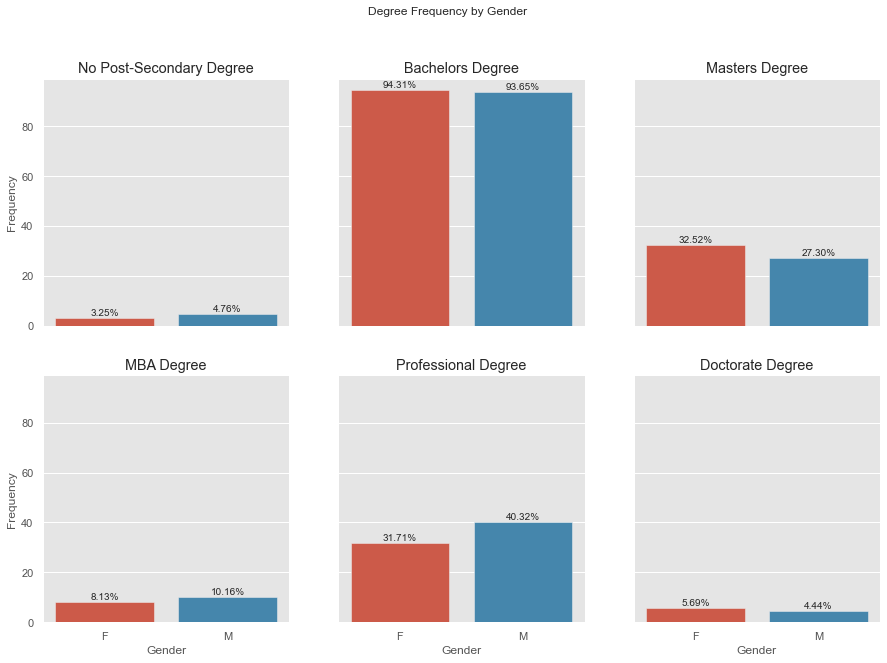

In [705]:
code_dict = {
    'No Post-Secondary': 'no_degree',
    'Bachelors': 'has_bach',
    'Masters': 'has_master',
    'MBA': 'has_business',
    'Professional': 'has_pro',
    'Doctorate': 'has_doctorate'
}

fig = plt.figure(figsize=(15,10))
gs = fig.add_gridspec(2,3)
axes = gs.subplots(sharex='col', sharey=True)

for i, key in enumerate(list(code_dict.keys())):
    ax = axes[i // 3][(i + 3) % 3]
    x = 'gender'
    y = code_dict[key]
    data = pd.DataFrame(df.groupby(x)[y].mean() * 100)
    data.reset_index(inplace=True)
    sns.barplot(data=data, x=x, y=y, ax=ax)
    ax.set_title(f'{key} Degree', loc='center')
    ax.set(xlabel=x.capitalize(), ylabel='Frequency')
    ax.label_outer()
    for j, p in enumerate(ax.patches):
        ax.annotate(
            '{val:.2f}%'.format(val=data[y][j]),
            (p.get_x() + p.get_width() / 2, p.get_height()),
            ha='center', va='center', xytext=(0, 5), textcoords='offset points'
        )

plt.suptitle('Degree Frequency by Gender')
plt.show()

## EDA

In [576]:
import scipy

### Statistical Tests
- $\alpha=0.05$

In [709]:
def chi_square_test(df, col1, key):
    col2 = code_dict[key]
    data = pd.DataFrame(df.groupby(col1)[col2].value_counts())
    data.columns = ['count']
    ob_freq = np.array(
        data.reset_index().pivot(index=col2, columns=col1, values='count')
    )

    prob = 0.95
    stat, p, dof, expected = scipy.stats.chi2_contingency(ob_freq)

    if abs(stat) >= scipy.stats.chi2.ppf(prob, dof):
        print(f'Reject Null - {col1} has relationship to {col2}')
    else:
        print(f'Cannot Reject Null - {col1} does not have relationship to {key}')

In [710]:
for key in code_dict.keys():
    chi_square_test(df, 'gender', key)

Cannot Reject Null - gender does not have relationship to No Post-Secondary
Cannot Reject Null - gender does not have relationship to Bachelors
Cannot Reject Null - gender does not have relationship to Masters
Cannot Reject Null - gender does not have relationship to MBA
Cannot Reject Null - gender does not have relationship to Professional
Cannot Reject Null - gender does not have relationship to Doctorate


In [711]:
for key in code_dict.keys():
    chi_square_test(df, 'current_party', key)

Cannot Reject Null - current_party does not have relationship to No Post-Secondary
Cannot Reject Null - current_party does not have relationship to Bachelors
Cannot Reject Null - current_party does not have relationship to Masters
Cannot Reject Null - current_party does not have relationship to MBA
Cannot Reject Null - current_party does not have relationship to Professional
Cannot Reject Null - current_party does not have relationship to Doctorate
